# DATA2 -  Random Frorests - baseline

## Features:
1. 'AGE' -> age
1. 'PTGENDER (Gender_)' -> Geder
1. 'RAVLT_immediate', -> RAVLT immediate
1. 'AVDEL30MIN_neuro' -> RAVLT delayed 
1. 'AVDELTOT_neuro', -> RAVLT recognition 
1. 'TRAASCOR_neuro', -> Trail Making A
1. 'TRABSCOR_neuro', -> Trail Making B
1. 'CATANIMSC_neuro' -> Category Fluency 
1. 'GDTOTAL_gds' -> GDS 
1. 'ANART' -> ANART
1. 'Apoe4' -> Apoe 4 
1. 'LRHHC_n_long' -> Hippocampus

---

**Resources**
1. DATA
    1. [data/data2](https://github.com/MMIV-ML/MCI-subgroups/tree/master/data/data2) - csv files downloaded from ADNI,
    1. [data/data2_FS](https://github.com/MMIV-ML/MCI-subgroups/tree/master/data/data2_FS) - FS result csv files,
    1. [data_zip/20201109_data2_file_versions](https://github.com/MMIV-ML/MCI-subgroups/blob/master/data/data_zip/20201109_data2_file_versions.pdf) - download ADNI web page screen shoot taken for downaloaded csv files (some of file neames are printed with dates),
1. RESULTS
    1. [results/20210420](https://github.com/MMIV-ML/MCI-subgroups/tree/master/results/20210420) - result folder,
    1. [results/202100420/README.md](https://github.com/MMIV-ML/MCI-subgroups/blob/master/results/20210420/README.md) - short description,
1. GOOGLE DRIVE
    1. [slides](https://docs.google.com/presentation/d/1aEK7M5BPe0RxWYskzQCEDbT4Mf-4mRRqQ5uJ_YuqRzg/edit#slide=id.p) - link to google slides (**OUT OF DATE, MUST BE UPDATED !!!**),
    1. [GoogleDrive](https://drive.google.com/drive/folders/1r8l2R88-0T8Xahk30iAgjBCWXvV1R2J-) - the main google drive slide folder,
1. GIT HUB
    1. [GitHub](https://github.com/MMIV-ML/MCI-subgroups) - the main repo folder,
1. MODEL ACCURACY COMPARISION
    1. [overview](https://github.com/MMIV-ML/MCI-subgroups/blob/master/results/20210420/3.xx_RF_bl_comparison.pdf) - to update!

The latest changes (ver. 0.10):

    -
    
   *Created: 2021.03.18 / Updated: 2021.04.30*
   
---

#### IMPORTS

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In /home/marek/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/marek/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/marek/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/marek/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/marek/minic

In [2]:
%config Completer.use_jedi = False

In [3]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

In [4]:
import mci_info as minfo
import mci_utils as mutils
import mci_freesurfer as mfs

In [5]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#### GLOBAL VARIABLES

In [6]:
# Notebook folder
NB_DIR = %pwd
NB_DIR = Path(NB_DIR)
# Root MCI foler
ROOT_DIR = NB_DIR.parent
# Main data folder (with downloaded csv files)
MAIN_DATA_DIR = ROOT_DIR/'data/data2'
DATA_DIR_FS = ROOT_DIR / 'data/data2_FS'
# Current data dir with sMCI_cAD.csv & bl.csv files
CURRENT_DATA_DIR = ROOT_DIR/'results/20201110'
# Results folder
RESULTS_DIR = ROOT_DIR/'results/20210420' #misclassified patient table
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

### INSTALLED PACKAGES INFO

In [7]:
if 1:
    packages = ['numpy', 'scipy', 'seaborn', 'pandas', 'matplotlib', 'statsmodels', 'ipywidgets', 'eli5', 'pdpbox']
    display(mutils.package_versions(installedOnly=False, theMostImportant=packages))



Computer name: mmiv-ml-titan
Operating system: Linux, 64bit

Python path: /home/marek/miniconda3/envs/py37/bin/python
Python version: 3.7.9 (default, Aug 31 2020, 12:42:55) 
[GCC 7.3.0]



,module,version
4,eli5,0.11.0
6,ipywidgets,7.6.3
10,matplotlib,3.3.4
12,numpy,1.19.2
14,pandas,1.1.5
15,pdpbox,0.2.1
19,scipy,1.5.2
20,seaborn,0.11.1
23,statsmodels,0.12.1


---

# TO CHANGE!!!

## SET FILE DESCRIPTIVE VARIABLES

In [8]:
features = ['AGE', 'Gender_', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro',
            'CATANIMSC_neuro','GDTOTAL_gds', 'ANARTERR_neuro', 'LRHHC_n_long', 'Apoe4_', 'Subgroup_']

file_name_prefix = '3.16-feats'

## LOAD BASE LINE FILE

In [9]:
bl_name = CURRENT_DATA_DIR / 'bl.csv'
bl_all = pd.read_csv(bl_name, index_col=0)

print(f'Subjects: \t{bl_all.shape[0]}')

Subjects: 	708


### CONVERTS STRING LABESLS TO INTS

In [10]:
#y_train_b = y_train.map({'cAD': 1, 'sMCI': 0}).astype(int)
bl_all['Gender_'] = bl_all['PTGENDER'].map({'Female':1, 'Male':0})
print(bl_all.PTGENDER.value_counts())
print(bl_all.Gender_.value_counts())

Male      425
Female    283
Name: PTGENDER, dtype: int64
0    425
1    283
Name: Gender_, dtype: int64


---

In [11]:
features2 = features + ['Usage_', 'Subgroup_', 'Participation_length_yr_', 'PTEDUCAT']
bl_xxx = bl_all[features2]
print(bl_xxx.shape)
bl_xxx.isnull().sum()

(708, 17)


AGE                          0
Gender_                      0
RAVLT_immediate              0
AVDEL30MIN_neuro             0
AVDELTOT_neuro               1
TRAASCOR_neuro               0
TRABSCOR_neuro              10
CATANIMSC_neuro              0
GDTOTAL_gds                  0
ANARTERR_neuro               6
LRHHC_n_long                14
Apoe4_                       0
Subgroup_                    0
Usage_                       0
Subgroup_                    0
Participation_length_yr_     0
PTEDUCAT                     0
dtype: int64

In [12]:
#bl_xxx.dropna(axis='rows', inplace=True)
#print(bl_xxx.shape)

In [13]:
#bl_xxx.head()

## SAVING 

In [14]:
#bl_xxx.to_csv('../Ingrid/data_ingrid/RF_train_test_exnan.csv', index = False)

---

#### SELECT TRAIN SUBSET

In [15]:
bl_train = bl_all.loc[bl_all.Usage_ == 'train']
bl_test = bl_all.loc[bl_all.Usage_ == 'test']

# backup of oryignal train data
bl_train_all_copy = bl_train.copy(deep=True)

---

### INFO

In [16]:
if 1:
    bl_tr_ln = bl_train.shape[0]
    bl_te_ln = bl_test.shape[0]
    bl_ln = bl_all.shape[0]

    print(f'Subjects:\n\t- train: {bl_tr_ln} ({bl_tr_ln / bl_ln *100:.0f}%)\n\t- test: {bl_te_ln} ({bl_te_ln / bl_ln *100 :.0f}%)\n')

    print('Subgroup count:\n')
    print('*** Train set ***')
    print(bl_train.Subgroup_.value_counts(dropna=False))
    print('\n*** Test set ***')
    print(bl_test.Subgroup_.value_counts(dropna=False))

Subjects:
	- train: 566 (80%)
	- test: 142 (20%)

Subgroup count:

*** Train set ***
sMCI    305
cAD     261
Name: Subgroup_, dtype: int64

*** Test set ***
sMCI    76
cAD     66
Name: Subgroup_, dtype: int64


### IDENTIFY COLUMN NAMES PRESENTED IN THE DATA

In [17]:
minfo.included_feature_info(bl_train, pattern='adni-adas-neuro-gds-_')

Total number of columns: 105



,adni (#30),adas (#16),neuro (#14),gds (#5),ours (#20)
0,ABETA,MERGE_long_adas,ANARTERR_neuro,EXAMDATE_gds,ADAS13_adni_Nr_
1,ADAS13_adni,Q10_adas,AVDEL30MIN_neuro,GDTOTAL_gds,Abeta_
2,AGE,Q11_adas,AVDELTOT_neuro,MERGE_long_gds,Age_at_scan_
3,APOE4,Q12_adas,AVTOT6_neuro,Phase_gds,Age_at_scan_rounded_
4,CDRSB,Q13_adas,AVTOTB_neuro,VISCODE2_gds,Age_bin_
5,DX,Q1_adas,CATANIMSC_neuro,,Age_rounded_
6,DX_bl,Q2_adas,CLOCKSCOR_neuro,,Apoe4_
7,EXAMDATE,Q3_adas,COPYSCOR_neuro,,Gender_
8,FAQ,Q4_adas,EXAMDATE_neuro,,Gender_num_
9,IMAGEUID,Q5_adas,MERGE_long_neuro,,Idx_


---

### SELECT SUBSET OF COLUMNS TO TRAIN CLASSIFIER

In [18]:
bl_train = bl_train[features]
bl_test = bl_test[features]

# CHANGE COLLUMN NAMES ???

# REMEMBER TO MAKE CODE CELL INSTEAD OF MARKDOWN. NEED TO ASK MAREK HOW TO GET THESE NAMES ALSO FOR PDP-PLOTS 

In [19]:
bl_train = bl_train.rename({'AGE':'Age',
                             'Gender_': 'Gender',
                             'RAVLT_immediate' : 'RAVLT immediate',
                             'AVDEL30MIN_neuro': 'RAVLT delayed',
                             'AVDELTOT_neuro': 'RAVLT recognition',
                             'TRAASCOR_neuro' : 'Trail Making A',
                             'TRABSCOR_neuro': 'Trail Making B',
                             'CATANIMSC_neuro': 'Category Fluency',
                             'GDTOTAL_gds': 'GDS',
                             'ANARTERR_neuro': 'ANART',
                             'Apoe4_' : 'Apoe 4',
                             'LRHHC_n_long': 'Hippocampus'}, axis='columns')

In [20]:
bl_test = bl_test.rename({'AGE':'Age',
                             'Gender_': 'Gender',
                             'RAVLT_immediate' : 'RAVLT immediate',
                             'AVDEL30MIN_neuro': 'RAVLT delayed',
                             'AVDELTOT_neuro': 'RAVLT recognition',
                             'TRAASCOR_neuro' : 'Trail Making A',
                             'TRABSCOR_neuro': 'Trail Making B',
                             'CATANIMSC_neuro': 'Category Fluency',
                             'GDTOTAL_gds': 'GDS',
                             'ANARTERR_neuro': 'ANART',
                             'Apoe4_' : 'Apoe 4',
                             'LRHHC_n_long': 'Hippocampus'}, axis='columns')

### COUNT NAN VALUES

In [21]:
if 1:
    print(' *** NaN values in TRAIN set ***' )
    print(bl_train.shape)
    print(bl_train.isnull().sum())
    
    print('\n\n *** NaN values in TEST set ***' )
    print(bl_test.shape)
    print(bl_test.isnull().sum())

 *** NaN values in TRAIN set ***
(566, 13)
Age                   0
Gender                0
RAVLT immediate       0
RAVLT delayed         0
RAVLT recognition     1
Trail Making A        0
Trail Making B       10
Category Fluency      0
GDS                   0
ANART                 4
Hippocampus          13
Apoe 4                0
Subgroup_             0
dtype: int64


 *** NaN values in TEST set ***
(142, 13)
Age                  0
Gender               0
RAVLT immediate      0
RAVLT delayed        0
RAVLT recognition    0
Trail Making A       0
Trail Making B       0
Category Fluency     0
GDS                  0
ANART                2
Hippocampus          1
Apoe 4               0
Subgroup_            0
dtype: int64


### REMOVE NAN VALUES


Remove those 11 rows from `bl_train` set.

In [22]:
bl_train = bl_train.dropna(axis='rows')
print(bl_train.shape)
bl_test = bl_test.dropna(axis='rows')
print(bl_test.shape)

(539, 13)
(139, 13)


In [23]:
if 1:
    print(' *** NaN values in TRAIN set ***' )
    print(bl_train.shape)
    print(bl_train.isnull().sum())
    
    print('\n\n *** NaN values in TEST set ***' )
    print(bl_test.shape)
    print(bl_test.isnull().sum())

 *** NaN values in TRAIN set ***
(539, 13)
Age                  0
Gender               0
RAVLT immediate      0
RAVLT delayed        0
RAVLT recognition    0
Trail Making A       0
Trail Making B       0
Category Fluency     0
GDS                  0
ANART                0
Hippocampus          0
Apoe 4               0
Subgroup_            0
dtype: int64


 *** NaN values in TEST set ***
(139, 13)
Age                  0
Gender               0
RAVLT immediate      0
RAVLT delayed        0
RAVLT recognition    0
Trail Making A       0
Trail Making B       0
Category Fluency     0
GDS                  0
ANART                0
Hippocampus          0
Apoe 4               0
Subgroup_            0
dtype: int64


---

## SAVING THESE "FINAL" TRAIN and TEST SETS (after removing subjects with NaN) 

In [24]:
#bl_train.to_csv('../Ingrid/data_ingrid/bl_train_RF.csv', index = False)

In [25]:
#bl_test.to_csv('../Ingrid/data_ingrid/bl_test_RF.csv', index = False)

---

## RANDOM FORESTS CLASSIFICATION

### CREATE X AND y

The split between `train` and `test` data is done in the ([2.11-data-balance](./2.11-data2-data-balance.ipynb)) notebook. To get chunk of data for traingin we use a 'train' flag in the `Usage_` column.

In [26]:
# train set
X_train = bl_train.copy(deep=True)
y_train = X_train.Subgroup_

# test set
X_test = bl_test.copy(deep=True)
y_test = X_test.Subgroup_

### REMOVE THE TARGET (`SUBGROUP_`) COLUMN FROM THE TRAIN SET

In [27]:
if 'Subgroup_' in X_train.columns:
    X_train = X_train.drop(columns='Subgroup_')
if 'Subgroup_' in X_test.columns:
    X_test = X_test.drop(columns='Subgroup_')

print(f'"Subgroup_" column in train set:\t{"Subgroup_" in X_train.columns}')
print(f'"Subgroup_" columm in test set: \t{"Subgroup_" in X_test.columns}')

"Subgroup_" column in train set:	False
"Subgroup_" columm in test set: 	False


In [28]:
# print size of train / test sets
if 1:
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

(539, 12) (539,)
(139, 12) (139,)


In [29]:
if 1:
    display(minfo.df_stats_info2(X_test))

,min,mean,max
Age,55.000,73.335,88.400
Gender,0.000,0.410,1.000
RAVLT immediate,20.000,34.014,65.000
RAVLT delayed,0.000,3.583,14.000
RAVLT recognition,1.000,10.647,15.000
Trail Making A,16.000,40.978,150.000
Trail Making B,38.000,116.338,300.000
Category Fluency,6.000,17.101,30.000
GDS,0.000,1.640,5.000
ANART,0.000,12.532,44.000


---

# GRID SEARCH (ONLY IF NEEDED)

In [ ]:
# Run gridsearch (if grid_search=1) and save the model to a file
# Load the best model from the file (if grid_search = 0)
grid_search = 1

# A filename of the the whole ridsearch structure
file_name_prefix_ext = file_name_prefix + '.pkl'
file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext

# define a stratification sheme
skf = StratifiedKFold(n_splits=10)

if grid_search:       
    print("Searching the best RF's parameters...")
    pipe = make_pipeline(StandardScaler(),RandomForestClassifier(random_state=42))
    #sorted(pipe.get_params().keys())

    params = {"randomforestclassifier__n_estimators": [50, 100, 150, 300, 470, 480, 490, 800, 1000, 100000],
              "randomforestclassifier__max_depth": [1,2, 3, 4, 5],
              "randomforestclassifier__max_features": [1,2, 3, 4, 5],
              "randomforestclassifier__min_samples_split": [1, 2, 3, 4],
              "randomforestclassifier__min_samples_leaf": [1, 2, 3, 4],
              "randomforestclassifier__bootstrap": [True, False],
              "randomforestclassifier__criterion": ["gini", "entropy"]}
    
    #params = {"randomforestclassifier__n_estimators": [373, 374, 375]}
    
    grid = GridSearchCV(estimator=pipe, param_grid=params, verbose=1, refit=True, cv=skf, n_jobs=48)
    # fit the best estimator to the train data
    grid.fit(X_train, y_train)
    # save best estimator to the file
    joblib.dump(grid, file_name_prefix_path)     
else:
    print("Loading RF from a file...")
    grid = joblib.load(file_name_prefix_path)     

    
clf = grid.best_estimator_

print()
print(f'Best score: {grid.best_score_:.3f}\n')
print(f'Best params:')
for k,v in grid.best_params_.items():
    print(f'\t{k}: {v}')
#print(grid.cv_results_)

Searching the best RF's parameters...
Fitting 10 folds for each of 16000 candidates, totalling 160000 fits


---

# A PIPELINE WITH ESTABLISHED RF PARAMETERS (WITHOUTH GRID SEARCH) 

### FEATURE STANDARIZATION IN THE TRAIN SET

In [92]:
# Standarization - standar scaler from scikit-learn
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled.set_index(X_train.index, inplace=True)

In [93]:
# OVERWRITE 
scaler = preprocessing.StandardScaler()
X_train_scaled = X_train
X_test_scaled = X_test

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled.set_index(X_train.index, inplace=True)

#### TABLE CONTENT CHECKING (OPTIONAL)

In [94]:
if 0:    
    tmp_df = pd.DataFrame.from_dict({'X_train_mean':X_train.mean().round(2), 'X_train_std':X_train.std().round(2), 
                        'X_train_scaled_mean':X_train_scaled.mean().round(2), 'X_train_scaled_std':X_train_scaled.std().round(2)})
    
    display(X_train.head())
    display(X_train_scaled.head())
    display(tmp_df)

### LABEL FEATURE MAPPING FROM STRING TO FINITE INT VALUES

In [95]:
print('*** Train set ***')
y_train_b = y_train.map({'cAD': 1, 'sMCI': 0}).astype(int)
print(y_train_b.value_counts())
print('\n*** Test set ***')
y_test_b = y_test.map({'cAD': 1, 'sMCI': 0}).astype(int)
print(y_test_b.value_counts())

*** Train set ***
0    283
1    256
Name: Subgroup_, dtype: int64

*** Test set ***
0    74
1    65
Name: Subgroup_, dtype: int64


---

# RF MODEL WITH CV (10 FOLDS)

Hyperparameters optimized May 3rd

In [96]:
folds = 10

#cls_save_name = 'cog_6_features'

skf = StratifiedKFold(n_splits=folds, shuffle=False)
clf = RandomForestClassifier(random_state=0,
                             n_estimators=480,
                             max_depth=4,
                             bootstrap=True,
                             criterion='gini',
                             min_samples_split=2,
                             min_samples_leaf=1,
                             max_features=4
                            )

# auxiliary structures (dfs, matrices) 
score = pd.DataFrame(index=[ 'f1_', 'acc_', 'recall_', 'prec_'], columns=list(range(folds)))
feat_importance_all = pd.DataFrame(index=X_train_scaled.columns, columns=list(range(folds)))
conf_matrix_all = np.zeros((folds, 2 ,2))
df_err_predictions = pd.DataFrame()
# to calculate mean validation test lenght, as it is 55 or 56
validation_test_length = np.ones(10)



for k, (train_index, validation_index) in enumerate(skf.split(X_train_scaled, y_train_b)):
    #print("TRAIN:", train_index.shape, "VAL:", test_index.shape)
    X_train, X_validation = X_train_scaled.iloc[train_index,:], X_train_scaled.iloc[validation_index,:]
    y_train, y_validation = y_train_b.iloc[train_index], y_train_b.iloc[validation_index]
         
    # model fit
    clf.fit(X_train, y_train)

    # predict
    y_pred = clf.predict(X_validation).reshape(-1,)
    
    # metrics
    f1 = metrics.f1_score(y_validation, y_pred)
    acc = metrics.accuracy_score(y_validation, y_pred)
    recall = metrics.recall_score(y_validation, y_pred)
    prec = metrics.precision_score(y_validation, y_pred)
    score[k] = [f1, acc, recall, prec]
    
    conf_matrix_all[k, :, :]  = metrics.confusion_matrix(y_validation, y_pred)    
    feat_importance_all[k] = clf.feature_importances_
    
    
    # add predictions and misclassifications to the training set
    X_validation_extended = X_validation.copy()
    X_validation_extended['y_true_'] = np.where(y_validation == 1, 'cAD', 'sMCI')
    X_validation_extended['y_pred_'] = np.where(y_pred == 1, 'cAD', 'sMCI')
    X_validation_extended['KFolds_nr_'] = f'k{folds}'
    X_validation_extended['Fold_nr_'] = k
    X_validation_extended['Usage2_'] = 'valid'
    
    # set current validation test set length
    validation_test_length[k] = len(y_validation)
    
    # df with misclasified subjects for the current fold
    err = X_validation_extended.loc[(X_validation_extended.y_true_ != X_validation_extended.y_pred_)]
    print(f'fold: {k}, errors: {err.shape[0]}/{y_validation.shape[0]}  ({err.shape[0]/y_validation.shape[0]*100 :.1f}%)')
    
    # df to agregate misclassifications from all folds
    df_err_predictions = pd.concat([df_err_predictions, err], axis=0)    

fold: 0, errors: 21/54  (38.9%)
fold: 1, errors: 16/54  (29.6%)
fold: 2, errors: 15/54  (27.8%)
fold: 3, errors: 14/54  (25.9%)
fold: 4, errors: 7/54  (13.0%)
fold: 5, errors: 11/54  (20.4%)
fold: 6, errors: 21/54  (38.9%)
fold: 7, errors: 13/54  (24.1%)
fold: 8, errors: 11/54  (20.4%)
fold: 9, errors: 19/53  (35.8%)


---

## MODEL ANALYSIS

### IDENTIFY MISCLCASSIFIED PATIENTS IN THE ORIGIN `BL` TABLE AND LINK BOTH TABLES

In [97]:
#idx = df_err_predictions.loc[df_err_predictions.fold_nr_ == 0].index
bl_miss = bl_train_all_copy.loc[df_err_predictions.index]

cols = ['y_true_', 'y_pred_', 'KFolds_nr_', 'Fold_nr_', 'Usage2_']
df_err_predictions = df_err_predictions[cols]
bl_miss = bl_miss.merge(df_err_predictions, how='left', left_index=True, right_index=True, indicator='MERGE_misclassification_k10_')
print(bl_miss.shape)
display(df_err_predictions.head())
minfo.iterate_patient_GUI(df_err_predictions, column='Fold_nr_')

(148, 111)


,y_true_,y_pred_,KFolds_nr_,Fold_nr_,Usage2_
89,sMCI,cAD,k10,0,valid
100,cAD,sMCI,k10,0,valid
108,sMCI,cAD,k10,0,valid
130,sMCI,cAD,k10,0,valid
167,sMCI,cAD,k10,0,valid


#### SAVE MISCLASSIFICATIONS TO THE FILE (OPTIONAL)

In [98]:
save = 1

if save:     
    filename = file_name_prefix + '_bl_missclassified.csv'
    bl_misclassified_name = RESULTS_DIR / filename
    bl_miss.sort_values(by=['RID'], inplace=True)    
    bl_miss.to_csv(bl_misclassified_name, index=True)

---

### FEATURE IMPORTANCE (OUT OF 10 FOLDS)

In [99]:
feat_importance_all.reset_index(inplace=True)
feat_importance_all = feat_importance_all.rename({'index': 'feature'}, axis='columns')

In [100]:
display(feat_importance_all)

,feature,0,1,2,3,4,5,6,7,8,9
0,Age,0.053920,0.056383,0.047710,0.050573,0.053259,0.060302,0.052229,0.052856,0.055437,0.051637
1,Gender,0.011526,0.009901,0.012502,0.010968,0.012111,0.014412,0.010862,0.011371,0.011760,0.009848
2,RAVLT immediate,0.276112,0.237902,0.255958,0.224871,0.236745,0.258946,0.245674,0.226565,0.232795,0.206679
3,RAVLT delayed,0.171270,0.182279,0.176673,0.171998,0.167383,0.168453,0.217083,0.192495,0.187631,0.197705
4,RAVLT recognition,0.056588,0.049036,0.052204,0.046303,0.048917,0.057334,0.064270,0.050851,0.051610,0.053060
5,Trail Making A,0.045493,0.054165,0.050699,0.048237,0.046183,0.048962,0.036012,0.044671,0.041521,0.041744
6,Trail Making B,0.067136,0.066656,0.067245,0.066057,0.062932,0.060451,0.060941,0.071584,0.051608,0.073585
7,Category Fluency,0.039596,0.043366,0.051491,0.039536,0.050125,0.049733,0.039632,0.037879,0.044215,0.038018
8,GDS,0.013067,0.011858,0.011234,0.011819,0.013951,0.011813,0.011209,0.016571,0.012154,0.013025
9,ANART,0.040392,0.042128,0.046674,0.056305,0.045874,0.047192,0.043554,0.044391,0.044285,0.042890


In [101]:
feat_importance_all_stats = pd.DataFrame.from_dict({'feature':feat_importance_all.feature, 'mean':feat_importance_all.mean(axis=1).round(2), 'std.':feat_importance_all.std(axis=1).round(2)})
feat_importance_all_stats.sort_values(by='mean',ascending=False)

,feature,mean,std.
2,RAVLT immediate,0.24,0.02
10,Hippocampus,0.21,0.02
3,RAVLT delayed,0.18,0.02
6,Trail Making B,0.06,0.01
0,Age,0.05,0.00
4,RAVLT recognition,0.05,0.01
5,Trail Making A,0.05,0.01
9,ANART,0.05,0.00
7,Category Fluency,0.04,0.01
11,Apoe 4,0.03,0.01


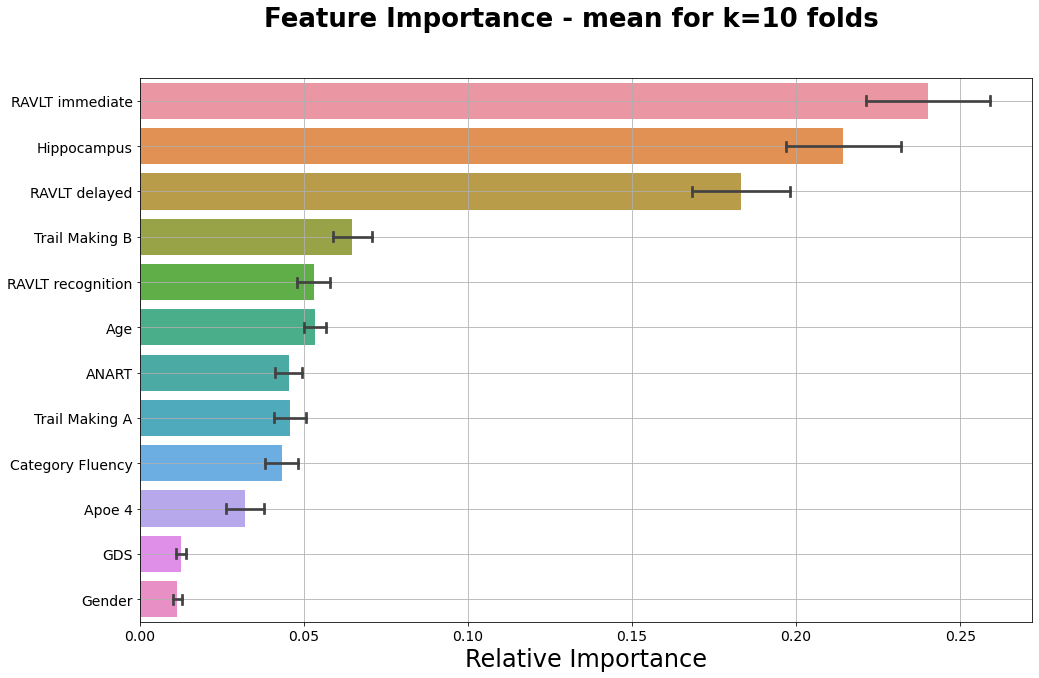

In [125]:
# transfer 2D df to 1D df (melt)
#https://stackoverflow.com/questions/40877135/plotting-two-columns-of-dataframe-in-seaborn
# label text size
#https://stackoverflow.com/questions/12444716/how-do-i-set-the-figure-title-and-axes-labels-font-size-in-matplotlib

fig, ax = plt.subplots(figsize=(16, 10))
fig.suptitle('Feature Importance - mean for k=10 folds', fontsize=26,fontweight='bold')
ax.set_xlabel('xlabel', fontsize=24)
ax.set_ylabel('ylabel', fontsize=24) 
ax.tick_params(labelsize=14)

tidy = feat_importance_all.melt(id_vars='feature').rename(columns=str.title)
tidy = tidy.sort_values(by=['Value'], ascending=False)
sns.barplot(y='Feature', x='Value', ci='sd', capsize=.2, data=tidy, ax=ax, orient="h")
# Add labels to your graph
plt.xlabel('Relative Importance', fontsize=24)
plt.ylabel('',fontsize=24)
plt.grid()


file_name_prefix_ext = f'{file_name_prefix}-TRAIN-feat-importance-horiz.png'
file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext
plt.savefig(file_name_prefix_path)


plt.show()

### (For vertical feat. imp. plot) 

fig, ax = plt.subplots(figsize=(30, 10))
fig.suptitle('Mean feature importance for k=10 folds', fontsize=26,fontweight='bold')
ax.set_xlabel('xlabel', fontsize=24)
ax.set_ylabel('ylabel', fontsize=24) 
ax.tick_params(labelsize=14)

#tidy = feat_importance_all.melt(id_vars='feature').rename(columns=str.title)
#tidy = tidy.sort_values(by=['Value'], ascending=False)
sns.barplot(x='Feature', y='Value', ci='sd', capsize=.2, data=tidy, ax=ax)
#sns.despine(fig)

file_name_prefix_ext = f'{file_name_prefix}-TRAIN-feat-importance-vert.png'
file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext
plt.savefig(file_name_prefix_path)

plt.grid()
plt.show()

---

### SCORES

In [103]:
display(score)
score_stats = pd.DataFrame.from_dict({'mean':score.mean(axis=1).round(3), 'std.':score.std(axis=1).round(4)})
display(score_stats)

,0,1,2,3,4,5,6,7,8,9
f1_,0.644068,0.733333,0.754098,0.766667,0.857143,0.792453,0.511628,0.734694,0.765957,0.654545
acc_,0.611111,0.703704,0.722222,0.740741,0.870370,0.796296,0.611111,0.759259,0.796296,0.641509
recall_,0.730769,0.846154,0.884615,0.884615,0.807692,0.807692,0.440000,0.720000,0.720000,0.720000
prec_,0.575758,0.647059,0.657143,0.676471,0.913043,0.777778,0.611111,0.750000,0.818182,0.600000


,mean,std.
f1_,0.721,0.0962
acc_,0.725,0.0857
recall_,0.756,0.1295
prec_,0.703,0.1087


---

### CONFUSION MATRIX

In [104]:
print(validation_test_length)
print(validation_test_length.mean())

[54. 54. 54. 54. 54. 54. 54. 54. 54. 53.]
53.9


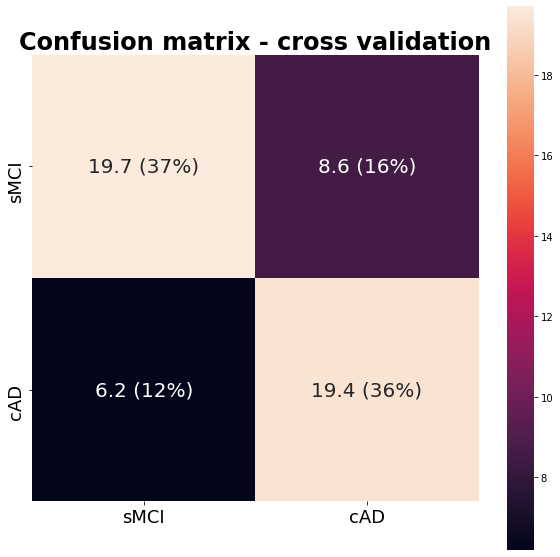

In [105]:
# mean of confusion matix over k=10 folds
conf_mat_mean = conf_matrix_all.mean(axis=0)
# percantage values of confusion matix according to validatin set lenght
conf_mat_mean_prc = conf_mat_mean / validation_test_length.mean() * 100


fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect(aspect=1)
lab = ['sMCI', 'cAD']
res = sns.heatmap(conf_mat_mean, annot=True, xticklabels=lab, yticklabels=lab, ax=ax,annot_kws={"fontsize":20}, fmt='.1f')
ax.tick_params(axis='both', which='major', labelsize=18)
_ = ax.set_title('Confusion matrix - cross validation', size=24, fontweight='bold')


for t,p in zip(res.texts, conf_mat_mean_prc.flat):
    p = np.asarray(np.round(p,0), int)
    t.set_text(t.get_text() + f' ({p}%)')
    
file_name_prefix_ext = f'{file_name_prefix}-TRAIN-conf-matrix.png'
file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext
plt.savefig(file_name_prefix_path)

## VISUALIZATION TREE

In [106]:
#https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c
# Extract single tree
#estimator = clf.estimators_[4]

#from sklearn.tree import export_graphviz
# Export as dot file
#export_graphviz(estimator, out_file='tree.dot', 
#                feature_names = X_train_scaled.columns,
#               class_names = ['sMCi','cAD'],
#                rounded = True, proportion = False, 
#                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
#from subprocess import call
#filename1 = file_name_prefix + '.png'
#filename2 = file_name_prefix + '.pdf'

#filepath1 = RESULTS_DIR/filename1
#filepath2 = RESULTS_DIR/filename2

#call(['dot', '-Tpng', 'tree.dot', '-o', filepath1, '-Gdpi=300'])
#call(['dot', '-Tpdf', 'tree.dot', '-o', filepath2, '-Gdpi=600'])

# Display in jupyter notebook
#from IPython.display import Image
#Image(filename = filepath1)

#### REMOVE TEMPORARY `tree.png` and `tree.dot` FILES FROM THE CURRENT FOLDER

In [107]:
#if 1:
#    [f.unlink() for f in list(Path('.').glob("tree.*"))]

---

# TEST SET

In [108]:
y_test_pred = clf.predict(X_test_scaled)
metrics.accuracy_score(y_test_b, y_test_pred)

0.6834532374100719

In [109]:
# predict
y_test_pred = clf.predict(X_test_scaled).reshape(-1,)

# metrics
f1 = metrics.f1_score(y_test_b, y_test_pred)
acc = metrics.accuracy_score(y_test_b, y_test_pred)
recall = metrics.recall_score(y_test_b, y_test_pred)
prec = metrics.precision_score(y_test_b, y_test_pred)

print(f'F1: {f1:.3f}')
print(f'ACC: {acc:.3f}')
print(f'RECALL: {recall:.3f}')
print(f'PREC: {prec:.3f}')

F1: 0.667
ACC: 0.683
RECALL: 0.677
PREC: 0.657


In [110]:
conf_matrix_test  = metrics.confusion_matrix(y_test_b, y_test_pred)    
print(conf_matrix_test)

[[51 23]
 [21 44]]


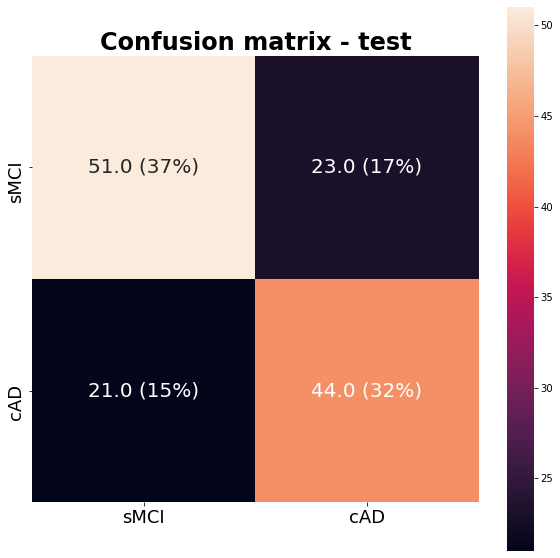

In [111]:
# mean of confusion matix over k=10 folds
conf_mat_mean = conf_matrix_all.mean(axis=0)
# percantage values of confusion matix according to validatin set lenght
conf_matrix_test_prc = conf_matrix_test / y_test.shape[0] * 100


fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect(aspect=1)
lab = ['sMCI', 'cAD']
res = sns.heatmap(conf_matrix_test, annot=True, xticklabels=lab, yticklabels=lab, ax=ax,annot_kws={"fontsize":20}, fmt='.1f')
ax.tick_params(axis='both', which='major', labelsize=18)
_ = ax.set_title('Confusion matrix - test', size=24, fontweight='bold')


for t,p in zip(res.texts, conf_matrix_test_prc.flat):
    p = np.asarray(np.round(p,0), int)
    t.set_text(t.get_text() + f' ({p}%)')
    
file_name_prefix_ext = f'{file_name_prefix}-TEST-conf-matrix.png'
file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext
plt.savefig(file_name_prefix_path)

In [121]:
feature_imp = pd.Series(clf.feature_importances_,index=X_train_scaled.columns).sort_values(ascending=False)
feature_imp

Hippocampus          0.234586
RAVLT immediate      0.206679
RAVLT delayed        0.197705
Trail Making B       0.073585
RAVLT recognition    0.053060
Age                  0.051637
ANART                0.042890
Trail Making A       0.041744
Category Fluency     0.038018
Apoe 4               0.037223
GDS                  0.013025
Gender               0.009848
dtype: float64

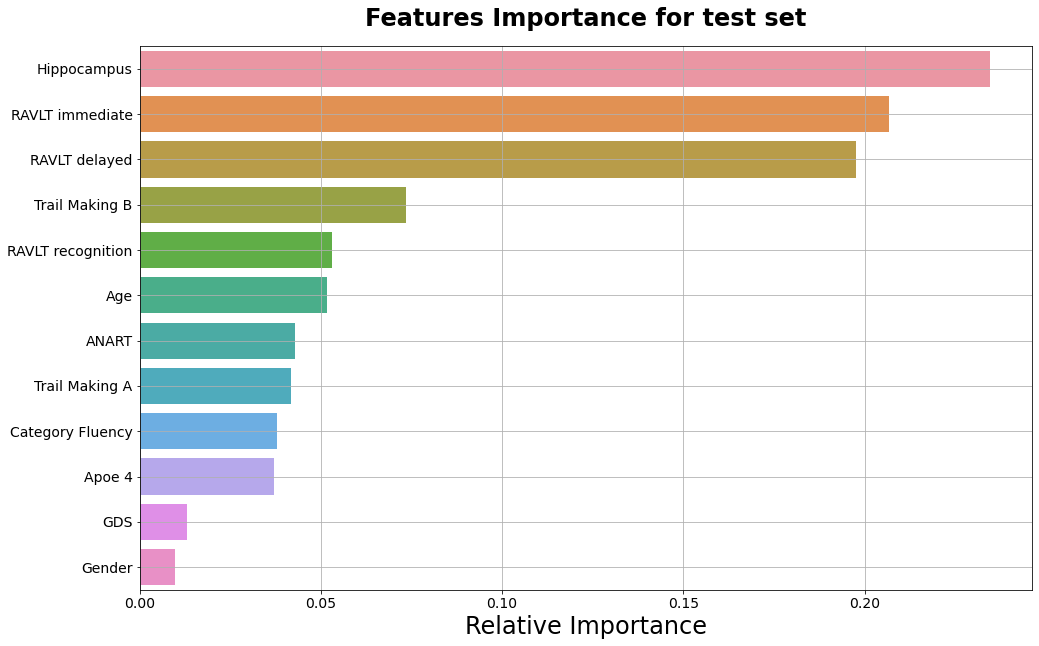

In [124]:
plt.figure(figsize=(16,10))
sns.barplot(x=feature_imp, y=feature_imp.index, ci='sd')

fig.suptitle('Features Importance test set', fontsize=26,fontweight='bold')
# Add labels to your graph
plt.xlabel('Relative Importance', fontsize=24)
plt.ylabel('',fontsize=24)
plt.title("Features Importance for test set", fontsize=24, fontweight='bold', pad=20)
plt.tick_params(labelsize=14)
plt.grid()

file_name_prefix_ext = f'{file_name_prefix}-TEST-feat-importance-horiz.png'
file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext
plt.savefig(file_name_prefix_path)


plt.show()

---

# FEATURE PERMUTATION

In [114]:
import eli5
from eli5.sklearn import PermutationImportance

In [115]:
perm = PermutationImportance(clf, random_state=42).fit(X_test_scaled, y_test_b)
X_test.head()
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0604 ± 0.0558,Hippocampus
0.0504 ± 0.0482,RAVLT immediate
0.0259 ± 0.0115,Trail Making B
0.0201 ± 0.0141,Trail Making A
0.0158 ± 0.0168,RAVLT recognition
0.0129 ± 0.0141,Gender
0.0101 ± 0.0115,Category Fluency
0.0072 ± 0.0129,ANART
0.0072 ± 0.0091,Apoe 4
0.0043 ± 0.0147,Age


# Partial dependece plots

In [116]:
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
print(X_test_df.shape)
display(X_test_df.head())

(139, 12)


,Age,Gender,RAVLT immediate,RAVLT delayed,RAVLT recognition,Trail Making A,Trail Making B,Category Fluency,GDS,ANART,Hippocampus,Apoe 4
6,80.4,1,30.0,1.0,7.0,49.0,168.0,13.0,0.0,17.0,0.003638,0.0
82,77.3,0,29.0,0.0,11.0,122.0,151.0,17.0,2.0,3.0,0.003343,1.0
184,77.5,1,35.0,1.0,10.0,27.0,69.0,24.0,2.0,22.0,0.003149,1.0
359,71.1,1,24.0,0.0,2.0,50.0,85.0,13.0,2.0,7.0,0.003729,0.0
384,83.6,1,30.0,2.0,9.0,22.0,76.0,18.0,0.0,9.0,0.003700,0.0


In [117]:
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
print(X_test_scaled_df.shape)
display(X_test_scaled_df.head())

(139, 12)


,Age,Gender,RAVLT immediate,RAVLT delayed,RAVLT recognition,Trail Making A,Trail Making B,Category Fluency,GDS,ANART,Hippocampus,Apoe 4
6,80.4,1,30.0,1.0,7.0,49.0,168.0,13.0,0.0,17.0,0.003638,0.0
82,77.3,0,29.0,0.0,11.0,122.0,151.0,17.0,2.0,3.0,0.003343,1.0
184,77.5,1,35.0,1.0,10.0,27.0,69.0,24.0,2.0,22.0,0.003149,1.0
359,71.1,1,24.0,0.0,2.0,50.0,85.0,13.0,2.0,7.0,0.003729,0.0
384,83.6,1,30.0,2.0,9.0,22.0,76.0,18.0,0.0,9.0,0.003700,0.0


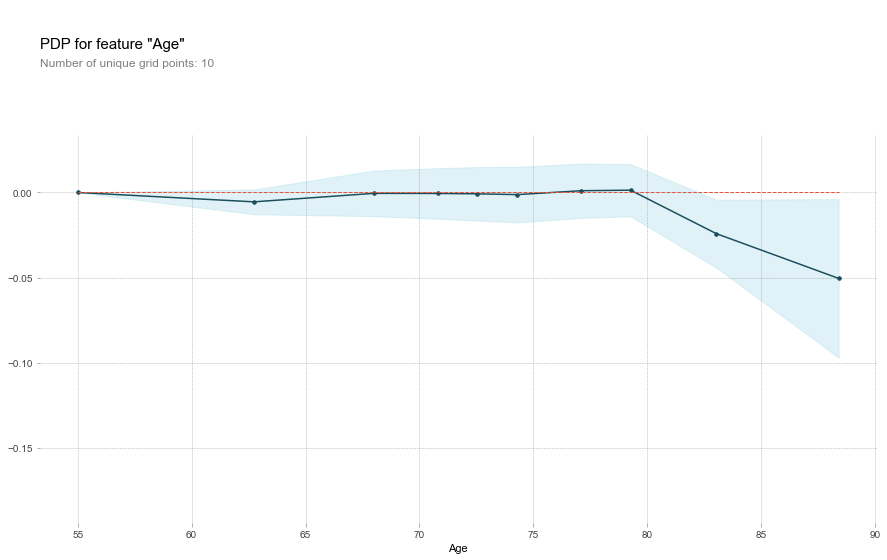

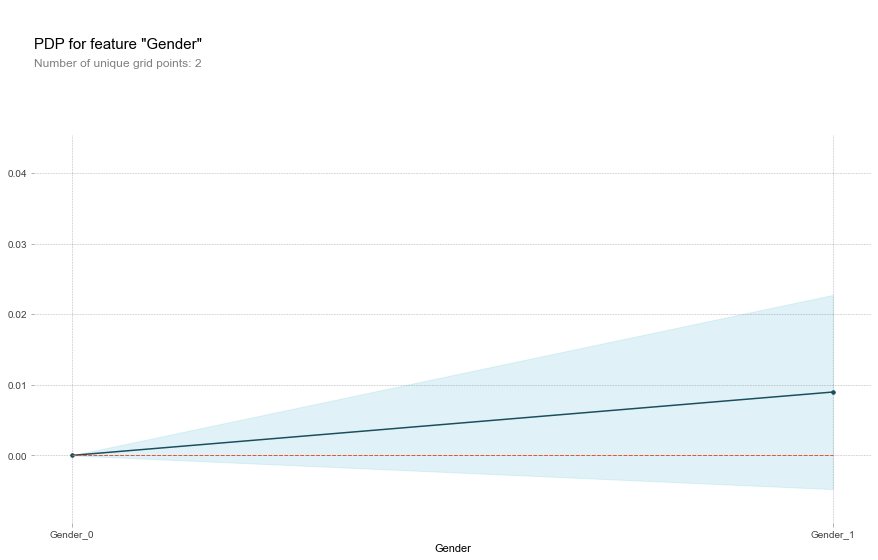

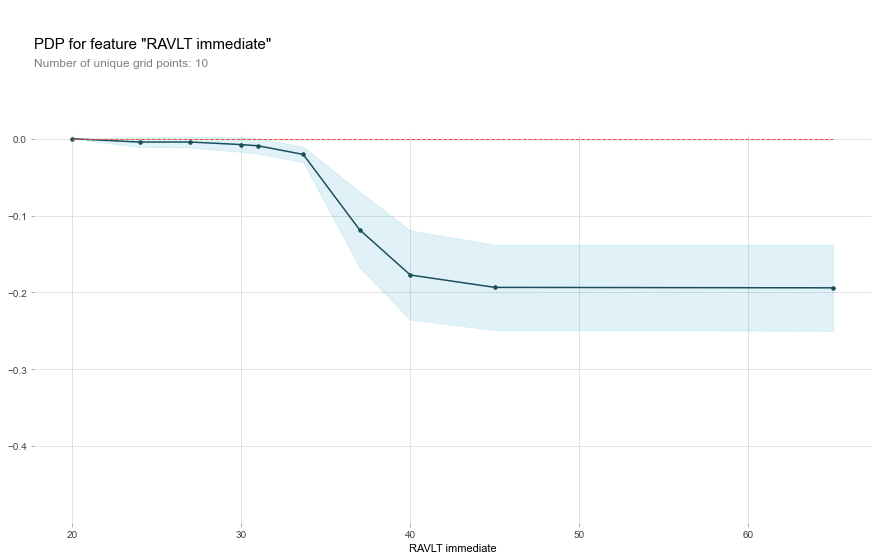

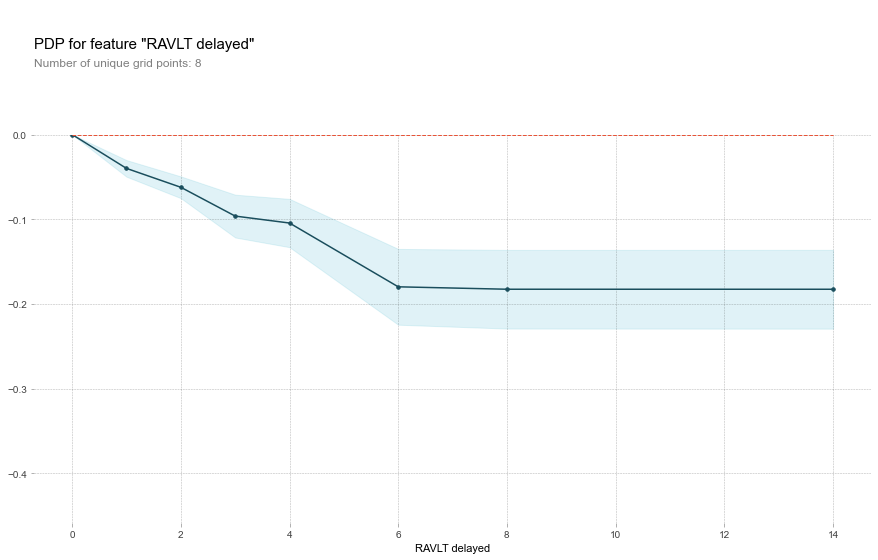

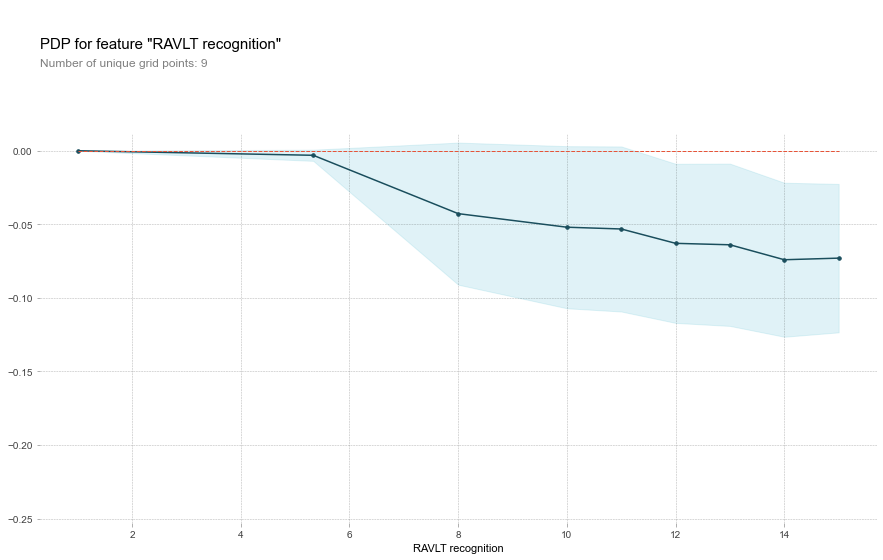

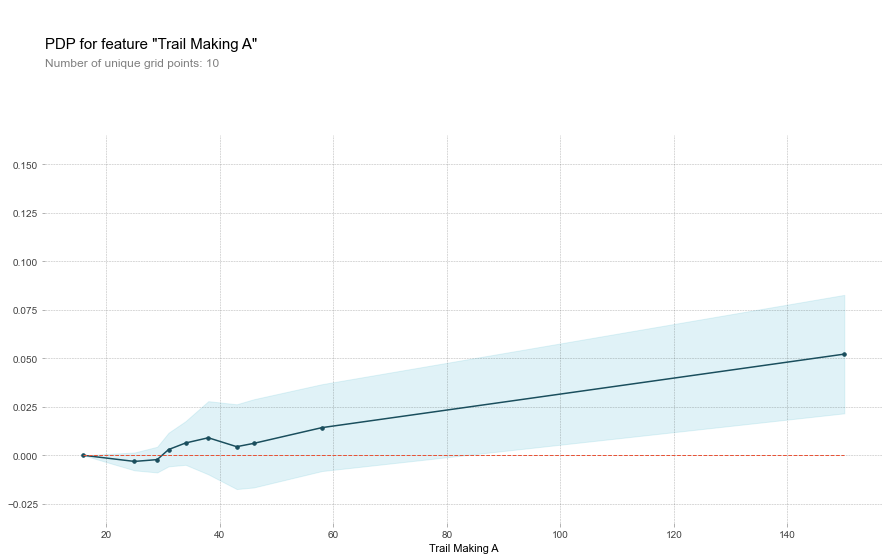

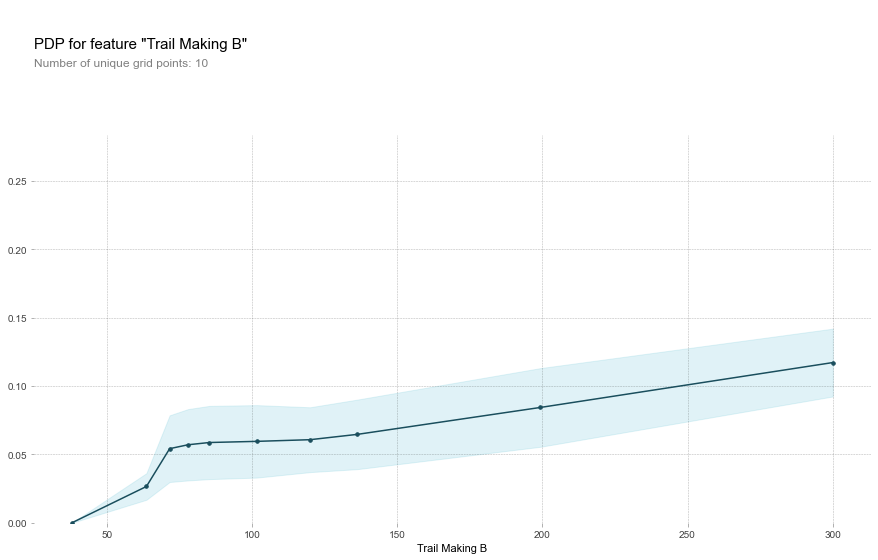

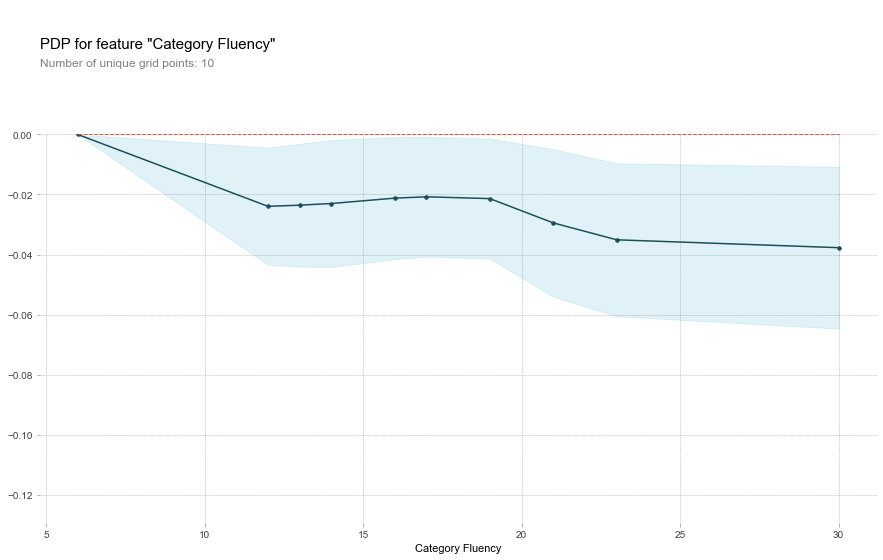

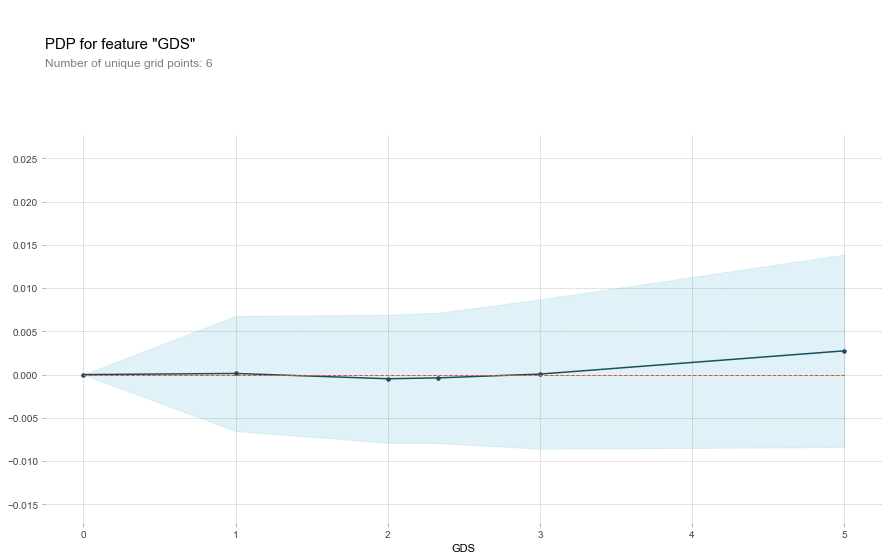

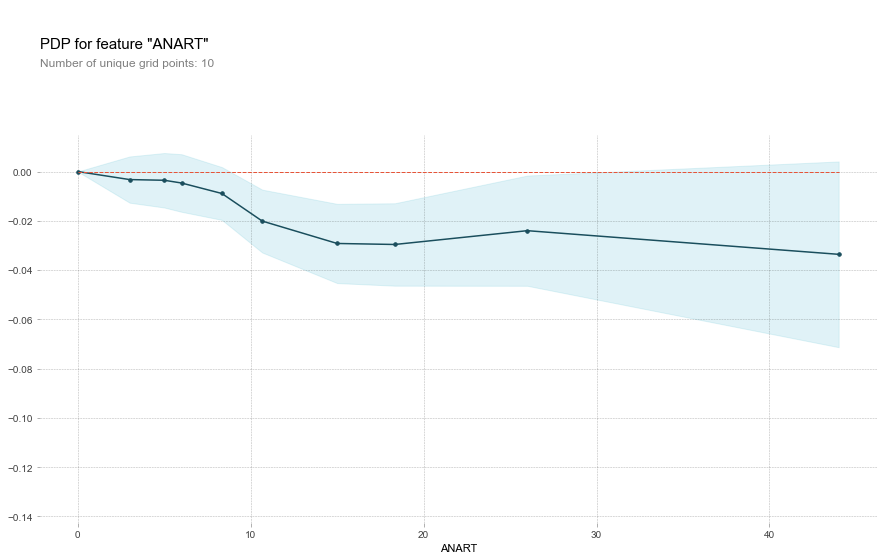

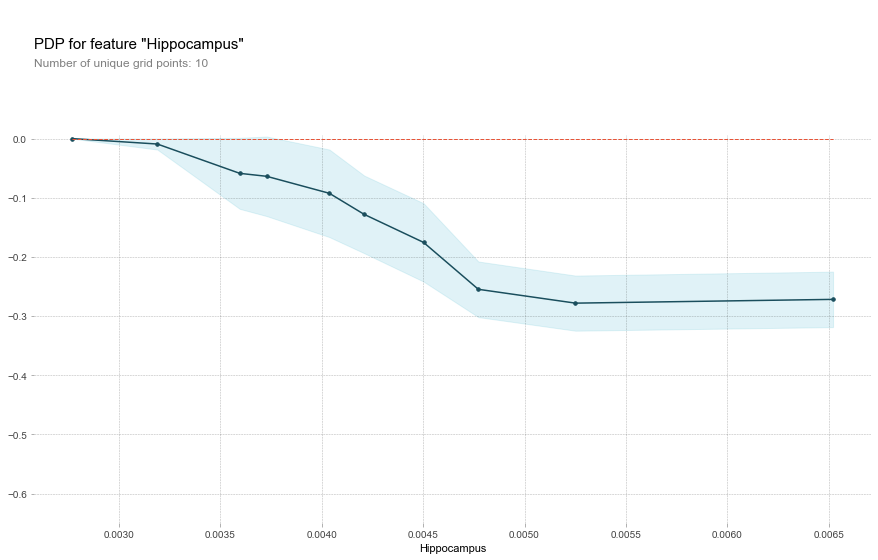

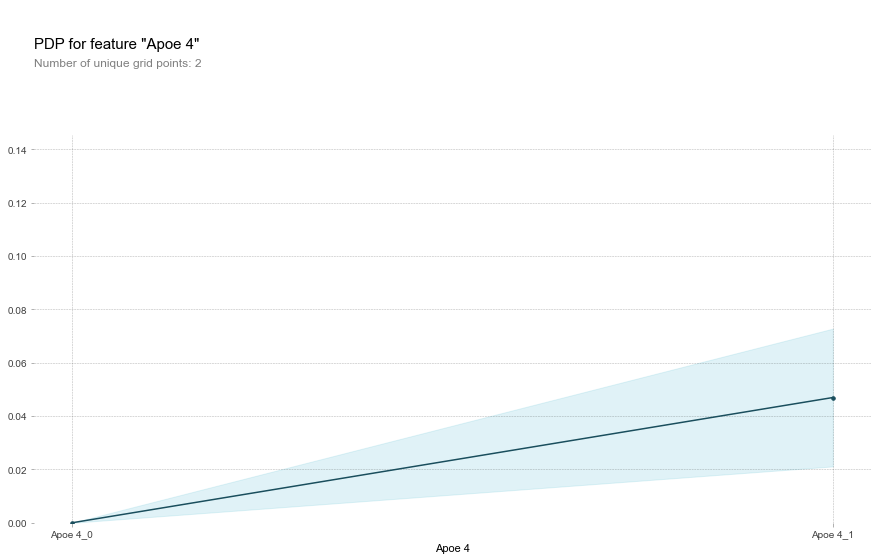

In [118]:
from pdpbox import pdp
if 'Subgroup_' in features: features.remove('Subgroup_')
for feature in X_test.columns:
    pdp_goals = pdp.pdp_isolate(model=clf, dataset=X_test_scaled_df, model_features=X_test.columns.tolist(), feature=feature)
    pdp.pdp_plot(pdp_goals, feature)

    file_name_prefix_ext = f'{file_name_prefix}-pdp-TEST-{feature}.png'
    file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext
    plt.savefig(file_name_prefix_path)

    plt.show()


---